In [1]:
# numpy 1.21.15
# pandas 1.4.2
# matplotlib 3.5.1
# seaborn 0.11.2
# nltk 3.7
# sklearn 1.1.2
# gensim 4.1.2
# transformers 4.22.2
# torch 1.12.1+cpu
# re 2.2.1
# IPython 8.2.0

In [2]:
import sklearn
sklearn.__version__

'1.1.2'

### Импортируем библиотеки

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from gensim.models import FastText
import torch 
import transformers as ppb
from IPython.display import display
from transformers import AutoTokenizer, AutoModel
from datetime import datetime, timedelta



from string import punctuation, digits, ascii_letters
punctuation += '—' + '«' + '»' + digits + ascii_letters
punctuation = punctuation.replace('-', '')

%matplotlib inline

### Импортируем файлы с описаниями профессий и данные новостей

In [4]:
dataset = pd.read_csv('data/dataset.csv')
dataset.head()

,id,source,topic,title,preamble,tldr,timestamp,body
0,5dd274649a7947720ac6c962,rbc,economics,Денежные переходы: 10 самых дорогих мостов России,NaN,"Стало известно, что цена строительства моста ч...",2022-09-29,"Стало известно, что цена строительства моста ч..."
1,62cc6de89a79475ea8638a76,rbc,finances,В App Store появилась замена удаленного из-за ...,NaN,"В App Store, магазине приложений для iPhone, п...",2022-08-16,"В App Store, магазине приложений для устройств..."
2,62f0fea09a7947d08b436a53,rbc,finances,Выдачи потребительских кредитов приблизились к...,Frank RG: банки в июле увеличили кредитование ...,В июле россияне получили кредиты наличными на ...,2022-08-09,Российские банки в июле 2022 года одобрили нас...
3,62f1344d9a7947ea40bd587d,rbc,finances,ЦБ усложнит выдачу кредитов бизнесу в «токсичн...,NaN,Банк России намерен ввести надбавки по ссудам ...,2022-08-08,ЦБ запланировал дифференцировать для банков вы...
4,62f134db9a7947ea1d38bdd9,rbc,finances,Путин разрешил банкам не работать в валюте стр...,NaN,Также президент разрешил ЦБ определять максима...,2022-08-08,"Президент Владимир Путин подписал указ, один и..."


In [5]:
dataset.shape

(6786, 8)

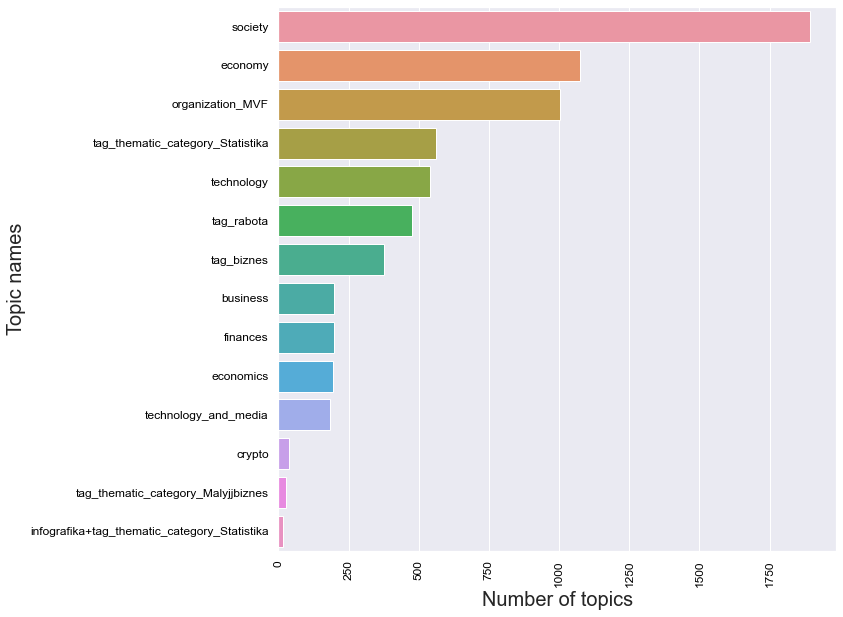

In [6]:
data_sort = dataset.groupby('topic').count().sort_values(by='title', ascending=False)

plt.figure(figsize=(10, 10))
plt.xticks(rotation=90)
y = data_sort.index
x = data_sort['title'].values
plt.tick_params(axis='both', which='major', labelsize=12, colors='black')
sns.barplot(y=y, x=x)
plt.xlabel('Number of topics', fontsize=20)
plt.ylabel('Topic names', fontsize=20)
plt.show()

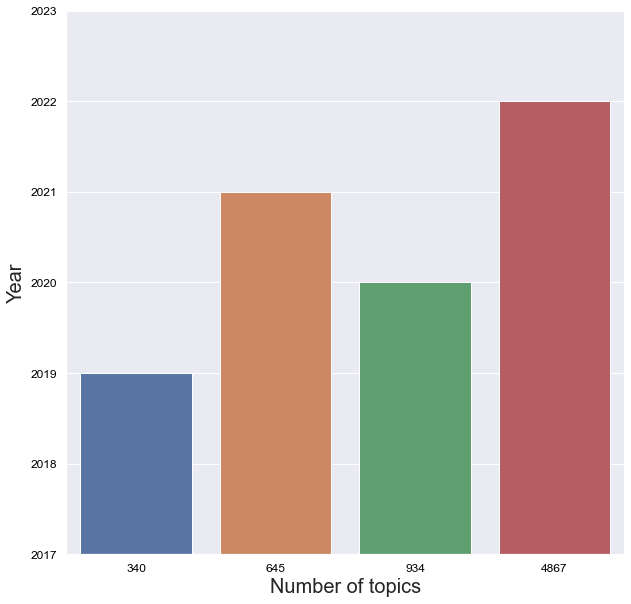

In [7]:
dataset_copy = dataset.copy()
dataset_copy['year'] = pd.to_datetime(dataset_copy['timestamp']).dt.year
data_sort = dataset_copy.groupby('year').count().sort_values(by='title', ascending=False)

plt.figure(figsize=(10, 10))
y = data_sort.index
x = data_sort['title'].values
plt.tick_params(axis='both', which='major', labelsize=12, colors='black')
sns.barplot(y=y, x=x)
plt.xlabel('Number of topics', fontsize=20)
plt.ylabel('Year', fontsize=20)
plt.ylim(2017, 2023)
plt.show()

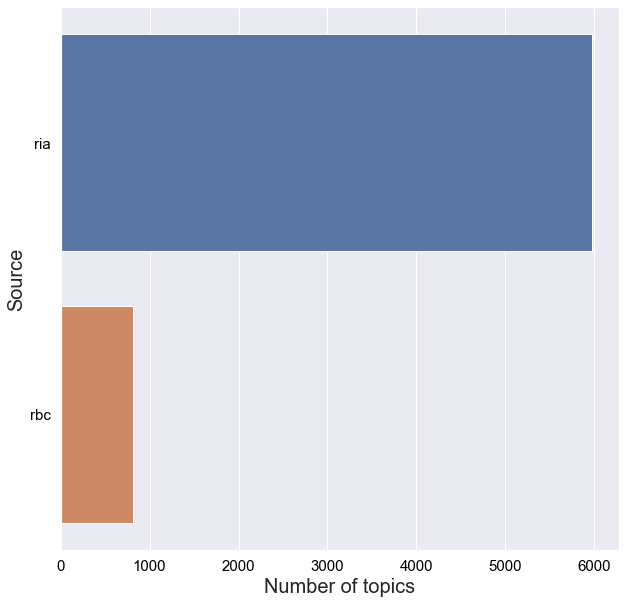

In [8]:
data_sort = dataset_copy.groupby('source').count().sort_values(by='title', ascending=False)

plt.figure(figsize=(10, 10))
y = data_sort.index
x = data_sort['title'].values
plt.tick_params(axis='both', which='major', labelsize=15, colors='black')
sns.barplot(y=y, x=x)
plt.xlabel('Number of topics', fontsize=20)
plt.ylabel('Source', fontsize=20)
plt.show()

### Обработаем данные о профессиях

In [9]:
def empl(link):
    with open(link, encoding='utf-8') as f:
        text = f.read()
        
    return text

In [10]:
empl1 = pd.DataFrame([{'title': empl('data/director1.txt').split(' ')[0], 'body': empl('data/director1.txt')}])
empl2 = pd.DataFrame([{'title': empl('data/бухгалтер.txt').split(' ')[0], 'body': empl('data/бухгалтер.txt')}])
empl = pd.concat([empl1, empl2])
empl.index = np.arange(0, empl.shape[0])

In [11]:
employees_new = empl.copy()
employees_new

,title,body
0,"CEO,","CEO, главный исполнительный директор, генераль..."
1,бухгалтер,бухгалтер Ведение бухгалтерского учета – обяза...


### Обработаем данные новостей и исследуем их

In [12]:
dataset = pd.read_csv('data/dataset.csv')
dataset = dataset[pd.to_datetime(dataset.timestamp).dt.year > 2018]
dataset.loc[dataset[dataset.body.str.startswith('МОСКВА')].index, 'body'] =\
    dataset[dataset.body.str.startswith('МОСКВА')].body.str.split('.').str[1:].str.join(' ')

In [13]:
dataset.index = dataset.id
dataset.drop(columns=['id'], inplace=True)
dataset.index.name = 'id'
dataset.timestamp = pd.to_datetime(dataset.timestamp)
dataset.drop(dataset[dataset.body.str.len() < 10].index, axis=0, inplace=True)

In [14]:
dataset2 = dataset.copy()
dataset2 = pd.concat([dataset2, employees_new])
dataset2 = dataset2.fillna('')
dataset2.body = dataset2.title + ' ' + dataset2.preamble + ' ' + dataset2.tldr + ' ' + dataset2.body

### TF-IDF для новостей

In [15]:
def tokenize_text(dataset, drop=True, stop_w=True):

    for p in (punctuation + '-'):
        dataset = dataset.replace(p, ' ')

    dataset = dataset.lower()
    tokens = word_tokenize(dataset)
    stop_words = set(stopwords.words('russian'))
    if(stop_w):
        tokens = [w for w in tokens if not w in stop_words]
    if (drop):
        stemmer = SnowballStemmer("russian")
        tokens = [stemmer.stem(i) for i in tokens]
    tokens = [i for i in tokens if len(i) > 2 ]

    return tokens

In [16]:
# max_features можно увеличить

vectorizer = TfidfVectorizer(tokenizer= lambda x: tokenize_text(x), max_features=20000)
body = vectorizer.fit_transform(dataset2.body)
df = pd.DataFrame(body.toarray(), columns=vectorizer.get_feature_names(), index=dataset2.index)

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [17]:
dataset1 = dataset2.drop(columns=['title', 'preamble', 'tldr', 'body', 'source', 'topic', 'timestamp'])
dataset1 = pd.merge(dataset1, df, left_index=True, right_index=True)

### SVD для полученной матрицы TF-IDF

In [18]:
tsvd = TruncatedSVD(n_components=min(dataset1.shape[0], 2000))
tf_idf_vectors = tsvd.fit_transform(dataset1)

In [19]:
nn1 = NearestNeighbors(n_neighbors=2)
nn1.fit([[1, 1.5, 1.25], [2, 2.5, 2.25]])

NearestNeighbors(n_neighbors=2)

In [20]:
nn1.kneighbors([[1, 1, 1]])

(array([[0.55901699, 2.1937411 ]]), array([[0, 1]], dtype=int64))

### KNN для матрицы SVD

In [55]:
# разделим на кластеры новости для CEO и бухгалтера

nn = NearestNeighbors(n_neighbors=400)
nn.fit((tf_idf_vectors[:-2] * 10000).astype('int'))
ids = nn.kneighbors((tf_idf_vectors[-2:] * 10000).astype('int'), n_neighbors=400)
data_director = dataset.iloc[ids[1][0]]
data_accountant = dataset.iloc[ids[1][1]]

In [56]:
data_director = data_director.append(employees_new.iloc[0])
data_accountant = data_accountant.append(employees_new.iloc[1])
display(data_director.head(3), data_accountant.head(3))

C:\Users\User\AppData\Local\Temp\ipykernel_9456\1253099401.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_director = data_director.append(employees_new.iloc[0])
C:\Users\User\AppData\Local\Temp\ipykernel_9456\1253099401.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_accountant = data_accountant.append(employees_new.iloc[1])


,source,topic,title,preamble,tldr,timestamp,body
id,,,,,,,
ria-targetolog-1749013098,ria,tag_rabota,Таргетолог: как стать специалистом по таргетированной рекламе,NaN,NaN,2021-09-07,"Профессия таргетолог востребована на рынке труда: любому виду бизнеса необходима грамотная подача В обязанности специалиста входит работа по настройке рекламы в соцсетях для решения поставленных задач О том, какие навыки нужно иметь, чтобы стать таргетологом, какие функции выполняет таргетированная реклама, какие перспективы развития в этой профессии — в материале РИА Новости \nТаргетолог — это маркетолог, специализирующийся на рекламе в социальных сетях, направленной на расширение покупательской аудитории того или иного продукта Таким образом, от его работы зависит популярность марки и доход от продаж Этот тип рекламы называется таргетированной (от английского target — цель): с помощью настроек специалист ограничивает круг пользователей, которым она будет видна, чтобы выйти на целевую аудиторию, где люди с большой вероятностью выполнят желаемое действие (пойдут на мероприятие, купят курсы и т д ) \nРабота по настройке таргетированной рекламы заключается в установлении определ..."
ria-kogan-1819619754,ria,economy,Евгений Коган: либерализация экономики поможет ответить на жесткие вызовы,NaN,NaN,2022-09-27,"В условиях беспрецедентного внешнеполитического давления российская промышленность и бизнес пытаются адаптироваться к новым непростым реалиям. Как в этом может помочь новая экономическая политика (НЭП 2.0) и какими должны быть главные шаги правительства по оживлению экономики в интервью РИА Новости рассказал профессор ВШЭ, инвестиционный банкир Евгений Коган.\n- Что происходит с экономикой России сегодня, как можно охарактеризовать ее состояние с точки зрения промышленности и бизнеса?\n- Сегодня наша экономика и бизнес переживают непростой период переосмысления и адаптации, понимания своего места в новых реалиях. С одной стороны – это попытки выживания в непривычных условиях, когда обрушились или рушатся внешние связи, идут санкции, уходят партнеры, рушится система транзакций, схемы работы и механизмы оптимизации финансовых потоков. Все это приходится выстраивать заново. С другой стороны – появилась возможность захвата новых ниш, освободившихся после ухода многих западных компаний,..."
ria-analitik-1756638664,ria,tag_biznes,Аналитик – незаменимый советник топ-менеджера и опора бизнеса,NaN,NaN,2021-11-24,"Аналитик – одна из самых востребованных позиций. Работать в такой должности можно, лишь обладая нужными знаниями. Чем занимается специалист этой профессии, рассказывает радио Sputnik.\nСбор данных, их структурирование и расшифровка, поиск общих тенденций, а затем приведение таблицы накопленных и проанализированных цифр в единую форму – это обязанности сотрудника, которого наняли на должность аналитика. Одна из главных задач аналитического отдела на любом предприятии – это прогноз, который строится на скрупулезно собранной информации. И как видно из обозначенных профессиональных обязанностей, аналитик – это не столько профессия, сколько обобщенное название должности на предприятиях совершенно разных сфер деятельности.\nСначала слово ""аналитик"" ассоциировалось у большинства с финансовым, банковским, брокерским делом. Теперь же без аналитического отдела не обходится ни одна крупная фирма, независимо от того, в какой области она работает – от биотехнологий до продажи мороженного.\nДля ..."


,source,topic,title,preamble,tldr,timestamp,body
id,,,,,,,
ria-bukhgalter-1752990757,ria,tag_rabota,Милый мой бухгалтер: кто стоит на страже финансов компании,NaN,NaN,2021-10-06,"Бухгалтер, пожалуй, важнейшая должность в любой организации. Вклад представителей этой специальности очень заметный, хотя и не такой броский, как у других профессий, отвечающих за законность работы. В чем суть бухгалтерского труда и каковы особенности этой сферы в России?\nВ любой компании, как известно, есть бухгалтер. А в крупных – даже несколько – по одному на каждый участок. Одни занимаются учетом средств компании, другие расчетами с контрагентами. Третьи ведают вопросами начисления заработной платы и премий. Четвертые отвечают за уплату налогов и т.д.\nБухгалтер – представитель финансовой службы, который отвечает за учет и систематизацию хозяйственных операций в соответствии с требованиями законодательства. По сути, все операции, сделки и факты из жизни компании счетный работник обрабатывает и систематизирует, чтобы потом отразить информацию в отчетности.\nТребования к бухгалтерам определены законом. Государство обязывает фирму вести бухгалтерский учет и отчитываться перед ним..."
ria-bukhgalter-1756327321,ria,tag_rabota,День бухгалтера: современные наследники храма Сатурна,NaN,NaN,2021-11-21,"В 2022 году в России День бухгалтера отмечается 21 ноября. Праздник появился после того, как Борис Ельцин подписал закон ""О бухгалтерии"". Радио Sputnik рассказывает о секретах профессии.\nУ специалистов по бухгалтерскому делу официально своего праздника нет. По большому счету, они могут отмечать его весь ноябрь – на предпоследний месяц года выпадают сразу три даты, которые могут считаться профессиональным праздником сотрудников, сводящих дебит с кредитом.\nОдин из профессиональных праздников бухгалтера отмечается 10 ноября – это Международный день бухгалтера. В этот день в 1494 году был опубликован первый труд, содержащий в том числе размышления о бухгалтерских счетах. В российской столице долгое время был популярен День московского бухгалтера, который отмечали 16 ноября. В некоторых компаниях празднуют 25 или 28 ноября – дни, когда в 1996 году вступил в силу Федеральный закон ""О бухучете"". Но основная дата, конечно, – это 21 ноября. Именно в этот день в том же 1996 году президент ..."
ria-professii-1788131621,ria,tag_rabota,"Банкир, менеджер, логист: плюсы экономических профессий и уровень зарплат",NaN,NaN,2022-05-12,"Специальности, относящиеся к экономической отрасли, пользуются у абитуриентов спросом Виды деятельности представителей экономических профессий, как выбрать подходящий профиль обучения и где получить образование, чтобы попасть в число востребованных специалистов, перспективы карьеры — в материале РИА Новости \nЭкономист, финансист, аудитор, бухгалтер — во многом схожие профессии, но есть и ряд различий Каждое направление имеет свою специфику и предполагает определенные способы обучения и варианты карьерного роста \nСогласно общероссийскому ""Классификатору специальностей по образованию"" (ОКСО) существует множество экономических профессий \nО самых популярных из них рассказал Юрий Михеев, руководитель департамента аналитики ""Зарплаты ру"":\nАудиторов можно разделить на две группы:\nВ мире экономических профессий выделяют более узкие направления — банкир, логист, товаровед, маркетолог, менеджер, ревизор Эти специалисты обладают навыками финансового анализа, логистики, бухгалтерии и..."


### Bert для получившейся матрицы новостей

In [57]:
# model_class, tokenizer_class, pretrained_weights = (
#     ppb.DistilBertModel, 
#     ppb.DistilBertTokenizer, 
#     'distilbert-base-uncased'
# )

# tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
# model = model_class.from_pretrained(pretrained_weights)

In [58]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny")

def embed_bert_cls(text, model, tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [59]:
# если 1, то вывести данные для CEO, если 0, то вывести данные для бухгалтера

flag = int(input())
if (flag):
    data = data_director.copy()
else: 
    data = data_accountant.copy()

# ввожу 0

0


In [60]:
# создадим столбец first_sentence для упрощенной работы с Bert

data['first_sentence'] = data.tldr
data.loc[data[data['first_sentence'].isna()].index, 'first_sentence'] = data[data['first_sentence'].isna()].body.str.split(' ').str[:50].str.join(' ')


In [61]:
data['data'] = data.first_sentence.apply(lambda x: tokenize_text(str(x), drop=False, stop_w=False))
train = data['data'].apply(lambda x: embed_bert_cls(x, model, tokenizer))

In [62]:
array = []
for tr in train.values:
    array.append(tr)
    
array = np.array(array)
df_train = pd.DataFrame(array)

### KNN для матрицы Bert

In [63]:
# релевантные новости для сотрудника

nn = NearestNeighbors(n_neighbors=10)
nn.fit(df_train[:-1])

ids = nn.kneighbors(df_train[-1:], n_neighbors=10)[1]
data_first = data.iloc[ids[0]]

In [64]:
pd.set_option('display.max_colwidth', 1000)
data_answer = data_first.drop(columns=['first_sentence', 'data'])
data_answer

,source,topic,title,preamble,tldr,timestamp,body
id,,,,,,,
ria-bukhgalter-1752990757,ria,tag_rabota,Милый мой бухгалтер: кто стоит на страже финансов компании,NaN,NaN,2021-10-06,"Бухгалтер, пожалуй, важнейшая должность в любой организации. Вклад представителей этой специальности очень заметный, хотя и не такой броский, как у других профессий, отвечающих за законность работы. В чем суть бухгалтерского труда и каковы особенности этой сферы в России?\nВ любой компании, как известно, есть бухгалтер. А в крупных – даже несколько – по одному на каждый участок. Одни занимаются учетом средств компании, другие расчетами с контрагентами. Третьи ведают вопросами начисления заработной платы и премий. Четвертые отвечают за уплату налогов и т.д.\nБухгалтер – представитель финансовой службы, который отвечает за учет и систематизацию хозяйственных операций в соответствии с требованиями законодательства. По сути, все операции, сделки и факты из жизни компании счетный работник обрабатывает и систематизирует, чтобы потом отразить информацию в отчетности.\nТребования к бухгалтерам определены законом. Государство обязывает фирму вести бухгалтерский учет и отчитываться перед ним..."
ria-svarschik-1767382384,ria,tag_rabota,Профессия сварщик: спрос велик и зарплата высока,NaN,NaN,2022-01-26,"Сварщик ценится везде. Поэтому его зарплата в 2021 году – выше средней по стране. На то, сколько он будет зарабатывать, влияют умения и опыт.\nСкучать сварщику точно не приходится. Он нужен на стройках, на заводах, сельхозпредприятиях, судостроительных верфях, в портах, самолетостроении… Словом, нет такой сферы, где могли бы обойтись без его услуг. Причем не стоит думать, что это только рутинная работа, например, при строительстве мостов, дорожных развязок и тоннелей. Сварщикам найдется дело и в рекламе, и в творческих мастерских, и в студиях художественной ковки, в частности.\nЧтобы получать удовольствие от работы, она должна нравится. Тогда и желание расти в профессии не будет казаться обузой. Применить свои навыки и потенциал сварщик может где угодно, даже в спорте – взять, например, Формулу-1, где от его таланта (при создании рамы гоночного болида) зависит успех всей команды. Чтобы стать профессионалом экстра класса, конечно, надо получить образование, получив соответствующие с..."
ria-kursy-1820948692,ria,society,"Выросло число москвичей, прошедших курсы по направлению службы занятости","Москвичей, прошедших курсы по направлению службы занятости, стало на 15 процентов больше",NaN,2022-10-02,"Москвичей, прошедших курсы профессионального образования по направлению службы занятости, стало на 15% больше, чем в прошлом году, сообщается на сайте мэра столицы \n""С начала года более 10 тысяч москвичей прошли курсы профессиональной переподготовки и повышения квалификации по направлению специалистов столичной службы занятости Это на 15% больше, чем за тот же период прошлого года"", - говорится в сообщении со ссылкой на руководителя департамента труда и социальной защиты населения Москвы Евгения Стружака \nПрограммы включают в себя тренинги и мастер-классы, направленные на развитие гибких навыков, а также дополнительное профессиональное образование Сотрудники службы занятости помогают соискателям, чья профессия оказалась невостребованной, и тем, кто хочет актуализировать и систематизировать свои знания \nОтмечается, что безработным, людям старше 50 лет и мамам с детьми дошкольного возраста доступно несколько сотен образовательных программ Кроме того, москвичи могут освоить раб..."
ria-bezrabotnye-1599982658,ria,tag_rabota,Как встать на биржу труда в 2022 году: пошаговая инструкция,NaN,NaN,2022-08-24,"Биржа труда соединяет работодателей и работников Как зарегистрироваться в центре занятости и получить пособие по безработице, кому оно полагается и какие документы потребуются, а также можно ли это сделать онлайн — в материале РИА Новости \nБиржа труда — это неофициальное название Центров занятости населения (ЦЗН) В такое госучреждение по месту жительства может обратиться